Step 1: generate distributions, explore attributes (Gaussian, Laplace, Pareto, Students)

In [2]:
import numpy as np
import pandas as pd 
import random
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
random_state=42
import warnings; warnings.simplefilter('ignore')

In [3]:
mu, sigma = 0, 0.1 # mean and standard deviation
gauss_iid = np.random.normal(mu, sigma, 1000)

loc, scale = 0., 1.
laplace_iid = np.random.laplace(loc, scale, 1000)

a, m = 3., 2.  # shape and mode
pareto_iid = (np.random.pareto(a, 1000) + 1) * m

student_iid = np.random.standard_t(10, size=1000)

<AxesSubplot:ylabel='Density'>

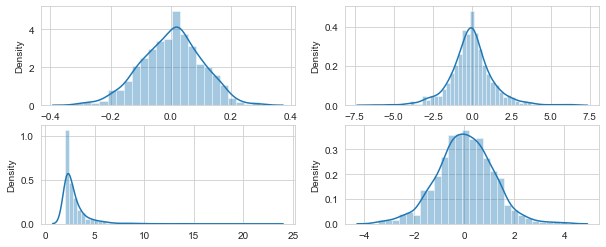

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,4))
sns.distplot(gauss_iid,ax=ax1)
sns.distplot(laplace_iid,ax=ax2)
sns.distplot(pareto_iid,ax=ax3)
sns.distplot(student_iid,ax=ax4)

Normal, student, and pareto all have real mean of 0.

Step 2: create the mean estimators class
- empirical mean
- median-of-means
- permutation-invariant median-of-means using Monte Carlo
http://faculty.washington.edu/yenchic/short_note/note_MoM.pdf

variable parameters:
- l = block size
- n = sample size
- N = # shuffles
- E = epsilon (accuracy parameter)

In [4]:
class meanEstimator():
    def __init__(self, sample, l, N):
        self.sample = sample  # sample from distribution
        self.n = len(sample)  # population size
        self.l = l  # number of chunks
        self.N = N  # number of shuffles
        self.empmean = sum(self.sample) / self.n

    def shuffle(self, seed):
        '''shuffles list with new random seed each time'''
        random_state = seed 
        shuffled = self.sample.copy()
        random.shuffle(shuffled)
        return shuffled

    def median_of_means(self, shuffled=None):
        '''returns median of means with specific l parameter (number of chunks)
        takes optional input parameter for repeated use in permutation-invariant MoM'''
        shuffled = self.sample if shuffled is None else shuffled
        chunks = np.array_split(np.array(shuffled), self.l)
        mom = statistics.median([statistics.mean(c) for c in chunks])
        return mom

    def perm_invar_mom(self):
        ''' repeats MoM process N times, shuffling each time'''
        seeds = np.random.randint(40, size=self.N)
        shuffled_lists = [self.shuffle(s) for s in seeds]
        mom_arr = [self.median_of_means(l) for l in shuffled_lists]
        return statistics.mean(mom_arr)
    

Let's look at the results of the mean estimators for our distributions for set parameter values:


In [10]:
n = 1000 # sample pop size
l = 10 # number of chunks
N = 10 # number of shuffles for permutation-invariant MoM

gauss_iid = np.random.normal(mu, sigma, n)
g_estimator = meanEstimator(gauss_iid, l, N) # new estimator object

student_iid = np.random.standard_t(10, size=n)
s_estimator = meanEstimator(student_iid, l, N) 

print('Estimates for Gaussian distribution ')
print(f' empirical mean: {g_estimator.empmean}\n MoM: {g_estimator.median_of_means()}\n permutation-invariant MoM: {g_estimator.perm_invar_mom()}\n')
print('Estimates for Student distribution ')
print(f' empirical mean: {s_estimator.empmean}\n MoM: {s_estimator.median_of_means()}\n permutation-invariant MoM: {s_estimator.perm_invar_mom()}\n')


Estimates for Gaussian distribution 
 empirical mean: 0.004149828056941171
 MoM: 0.002810918318011265
 permutation-invariant MoM: 0.004154480613830246

Estimates for Student distribution 
 empirical mean: -0.009698310298282366
 MoM: -0.035913416649425246
 permutation-invariant MoM: -0.00015529760179375249



Step 3: Define probability function 
- This generates a probability of an estimator generating a value within 'epsilon' of the real mean. 
- Without resampling, the MoM returns the same value each time. I had to use new samples for this reason.
- Each sample instantiates a new estimator object. Development-wise, this is not ideal because of the amounts of values stored, so if I had more time I would focus on optimizing code efficiency.
- In the same vein, there is some ugly repeated code here which I would ideally modularize further.
- For this experiment I am using distributions with a mean of 0. 
- Ideally we repeat the sampling a large number of times, but I ran into efficiency issues and had to decrease the number of samples to prevent the plot generation from taking too long. 

In [5]:
def prob_of_mean(n,l,N,epsilon):
    g_means = []
    g_moms = []
    g_moms_pi = []

    s_means = []
    s_moms = []
    s_moms_pi = []

    for i in range(30):
        random_state = i
        g_dist = np.random.normal(0, 0.1, n)
        g_e = meanEstimator(g_dist, l, N)
        g_means.append(g_e.empmean)
        g_moms.append(g_e.median_of_means())
        g_moms_pi.append(g_e.perm_invar_mom())

        s_dist = np.random.standard_t(10, size=n)
        s_e = meanEstimator(s_dist, l, N)
        s_means.append(s_e.empmean)
        s_moms.append(s_e.median_of_means())
        s_moms_pi.append(s_e.perm_invar_mom())

    g_means_probs = [1 if abs(m - 0) <= epsilon else 0 for m in g_means]
    g_moms_probs = [1 if abs(m - 0) <= epsilon else 0 for m in g_moms]
    g_moms_pi_probs = [1 if abs(m - 0) <= epsilon else 0 for m in g_moms_pi]
    s_means_probs = [1 if abs(m - 0) <= epsilon else 0 for m in s_means]
    s_moms_probs = [1 if abs(m - 0) <= epsilon else 0 for m in s_moms]
    s_moms_pi_probs = [1 if abs(m - 0) <= epsilon else 0 for m in s_moms_pi]

    return [statistics.mean(g_means_probs), statistics.mean(g_moms_probs), statistics.mean(g_moms_pi_probs),\
            statistics.mean(s_means_probs), statistics.mean(s_moms_probs), statistics.mean(s_moms_pi_probs)]


Step 4: Explore and graph probability values of different parameters

Different values for epsilon

Text(0.5, 1.0, "Probability of 'MoM' within various E of real mean")

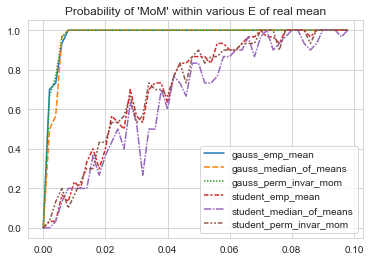

In [244]:
n = 1000 # sample pop size
l = 10 # number of chunks
N = 10 # number of shuffles for permutation-invariant MoM
e = np.arange(0.0, 0.1, 0.002)

mom_probs = [prob_of_mean(n, l, N, i) for i in e]

df = pd.DataFrame({
    'gauss_emp_mean':[x[0] for x in mom_probs],
    'gauss_median_of_means': [x[1] for x in mom_probs],
    'gauss_perm_invar_mom': [x[2] for x in mom_probs],
    'student_emp_mean':[x[3] for x in mom_probs],
    'student_median_of_means': [x[4] for x in mom_probs],
    'student_perm_invar_mom': [x[5] for x in mom_probs]
}, index=[i for i in e])

sns.lineplot(data=df)
plt.title("Probability of 'MoM' within various E of real mean")

The permutation-invariant MoM performs consistently better than regular MoM with the fat-tailed student distribution, and similarly to the empirical mean. There is no discernible difference in performance with the standard normal distribution. This is probably due to the fact that I am taking new samples from the distribution each time. While both estimators perform well at epsilon = 0.01 for the normal distrubution, consistently high probability scores only appear at epsilon = 0.08 for the student distribution.

Setting epsilon = 0.01
Testing different values for n (population size)

Text(0.5, 1.0, "Probability of 'MoM' within 0.01 of real mean at increasing population sizes")

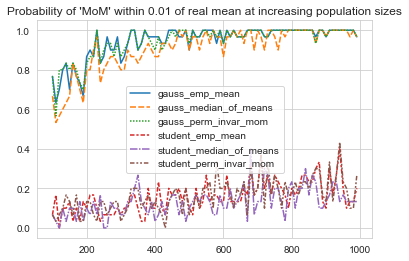

In [246]:
n = range(100,1000,10) # sample pop size, increments of 5
l = 10 # number of chunks
N = 10 # number of shuffles for permutation-invariant MoM
e = 0.01 # value decided from previous run

mom_probs = [prob_of_mean(i, l, N, e) for i in n]

df = pd.DataFrame({
    'gauss_emp_mean':[x[0] for x in mom_probs],
    'gauss_median_of_means': [x[1] for x in mom_probs],
    'gauss_perm_invar_mom': [x[2] for x in mom_probs],
    'student_emp_mean':[x[3] for x in mom_probs],
    'student_median_of_means': [x[4] for x in mom_probs],
    'student_perm_invar_mom': [x[5] for x in mom_probs]
}, index=[i for i in n])

sns.lineplot(data=df)
plt.title("Probability of 'MoM' within 0.01 of real mean at increasing population sizes")


Text(0.5, 1.0, "Probability of 'MoM' within 0.01 of real mean at increasing number of chunks")

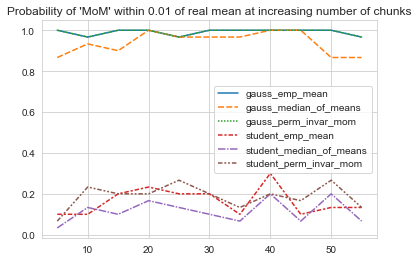

In [249]:
n = 600 # sample pop size, increments of 5
l = range(5,60,5) # number of chunks
N = 10 # number of shuffles for permutation-invariant MoM
e = 0.01 # value decided from previous run

mom_probs = [prob_of_mean(n, i, N, e) for i in l]

df = pd.DataFrame({
    'gauss_emp_mean':[x[0] for x in mom_probs],
    'gauss_median_of_means': [x[1] for x in mom_probs],
    'gauss_perm_invar_mom': [x[2] for x in mom_probs],
    'student_emp_mean':[x[3] for x in mom_probs],
    'student_median_of_means': [x[4] for x in mom_probs],
    'student_perm_invar_mom': [x[5] for x in mom_probs]
}, index=[i for i in l])

sns.lineplot(data=df)
plt.title("Probability of 'MoM' within 0.01 of real mean at increasing number of chunks")


As expected, not much of a trend in the student distribution since the estimators are not precise enough to fall within the epsilon range. Let's try that again with a smaller margin for the epsilon value to see if the trends for the normal distrubution show a clearer pattern.

Text(0.5, 1.0, "Probability of 'MoM' within 0.005 of real mean at increasing number of chunks")

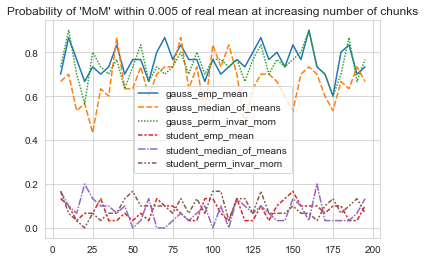

In [253]:
n = 600 # sample pop size, increments of 5
l = range(5,200,5) # number of chunks
N = 10 # number of shuffles for permutation-invariant MoM
e = 0.005 # value decided from previous run

mom_probs = [prob_of_mean(n, i, N, e) for i in l]

df = pd.DataFrame({
    'gauss_emp_mean':[x[0] for x in mom_probs],
    'gauss_median_of_means': [x[1] for x in mom_probs],
    'gauss_perm_invar_mom': [x[2] for x in mom_probs],
    'student_emp_mean':[x[3] for x in mom_probs],
    'student_median_of_means': [x[4] for x in mom_probs],
    'student_perm_invar_mom': [x[5] for x in mom_probs]
}, index=[i for i in l])

sns.lineplot(data=df)
plt.title("Probability of 'MoM' within 0.005 of real mean at increasing number of chunks")


These results are not very conclusive. The empirical mean is staying relatively constant, and the permutation-invariant MoM estimator performs better than the regular MoM, but there is no clear trend of improvement with increasing numbers of chunks. It could possibly become clearer with more estimation samples, but I am unable to generate a graph with more samples due to computational time constraints.

Text(0.5, 1.0, "Probability of 'MoM' within 0.005 of real mean at increasing number of shuffles")

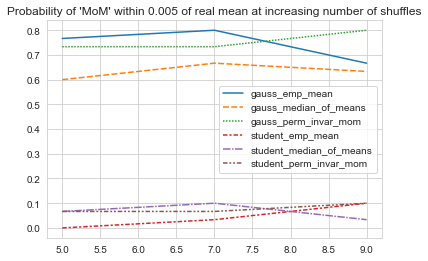

In [6]:
n = 600 # sample pop size, increments of 5
l = 10 # number of chunks
N = range(5,10,2) # number of shuffles for permutation-invariant MoM
e = 0.005 # value decided from previous run

mom_probs = [prob_of_mean(n, l, N, e) for i in N]

df = pd.DataFrame({
    'gauss_emp_mean':[x[0] for x in mom_probs],
    'gauss_median_of_means': [x[1] for x in mom_probs],
    'gauss_perm_invar_mom': [x[2] for x in mom_probs],
    'student_emp_mean':[x[3] for x in mom_probs],
    'student_median_of_means': [x[4] for x in mom_probs],
    'student_perm_invar_mom': [x[5] for x in mom_probs]
}, index=[i for i in N])

sns.lineplot(data=df)
plt.title("Probability of 'MoM' within 0.005 of real mean at increasing number of shuffles")


Here again I ran into a computational constraint because of how I am storing random seeds in a numpy matrix. My notebook runs out of memory when storing objects from multiple N runs, so I had to severely limit the number of repetitions. I only ran into this constraint when calculating the probability, which requires many iterations of this object.